<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/ImageGPT/Linear_probing_with_ImageGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear probing with ImageGPT

In this notebook, we are going to perform "linear probing" using a pre-trained [ImageGPT](https://openai.com/index/image-gpt/). What does that mean?

Linear probing means fitting a linear classifier (like logistic regression) on the fixed features of a pre-trained model. In other words, we will only use ImageGPT to produce fixed features X of images, on which we will then fit a linear classifier together with the labels y. The task of interest is image classification.

As shown in the [ImageGPT paper](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf), fitting a linear classifier on ImageGPT's features results in 96.3% accuracy on CIFAR-10. Also interesting to note is that the best features lie in the middle of ImageGPT's network, rather than at the end. This is probably explained by the fact that ImageGPT's pre-training objective is producing the next pixel, which might not be that helpful for image classification. Hence the model first builds a "global image representation" in the middle of the network, which is then used for conditional image generation.

Note that the features we are going to use are learned entirely unsupervised (i.e. without any labels). Hence, it's impressive that we can achieve high image classification accuracy using these features.

## Set-up environment

In [1]:
!pip install -q transformers datasets

## Download data

In [2]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes)
# train_ds, test_ds = load_dataset('cifar10', split=['train[:10]', 'test[:10]'])
# split up training into training + validation
# splits = train_ds.train_test_split(test_size=0.1)
# train_ds = splits['train']
# val_ds = splits['test']

dataset = load_dataset('cifar10')

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

## Load ImageGPT

First, let's load ImageGPT as well as its feature extractor (which can be used to prepare images for the model). We'll move the model to GPU for faster inference.

In [7]:
from transformers import ImageGPTImageProcessor, ImageGPTModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_processor = ImageGPTImageProcessor.from_pretrained("openai/imagegpt-small")
model = ImageGPTModel.from_pretrained("openai/imagegpt-small")
model.to(device)

Loading weights:   0%|          | 0/243 [00:00<?, ?it/s]

ImageGPTModel LOAD REPORT from: openai/imagegpt-small
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
transformer.h.{0...23}.attn.bias        | UNEXPECTED |  | 
transformer.h.{0...23}.attn.masked_bias | UNEXPECTED |  | 
lm_head.weight                          | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


ImageGPTModel(
  (wte): Embedding(513, 512)
  (wpe): Embedding(1024, 512)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-23): 24 x ImageGPTBlock(
      (ln_1): ImageGPTLayerNorm()
      (attn): ImageGPTAttention(
        (c_attn): Conv1D(nf=1536, nx=512)
        (c_proj): Conv1D(nf=512, nx=512)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): ImageGPTLayerNorm()
      (mlp): ImageGPTMLP(
        (c_fc): Conv1D(nf=2048, nx=512)
        (c_proj): Conv1D(nf=512, nx=2048)
        (act): QuickGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): ImageGPTLayerNorm()
)

## Preprocess data

Let's show how we can obtain a fixed-size feature vector for a single image. This involves 2 things: 1) use ImageGPTFeatureExtractor to prepare the image for the ImageGPT model 2) extract the hidden states of a particular layer, averaged along the sequence dimension.

In [5]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

encoding = image_processor(image, return_tensors="pt")
input_ids = encoding.input_ids.to(device)
print(input_ids.shape)

torch.Size([1, 1024])


In [6]:
# forward pass
outputs = model(input_ids, output_hidden_states=True)
hidden_states = outputs.hidden_states
print(len(hidden_states))

25


Here, we take the hidden states from the middle of the network (which, according to the paper, results in the best image classification performance), and average them across the sequence (also called time) dimension. This is just a vector of shape `(batch_size, hidden_size)` - the hidden size for the small ImageGPT model is 512.

In [7]:
feature_vector = torch.mean(hidden_states[13], dim=1)
feature_vector.shape

torch.Size([1, 512])

Now that we've shown how to do this for a single image, let's now do this for the entire dataset. We can do this fast using HuggingFace Datasets' `.map(function, batched=True)` functionality.

In [8]:
import numpy as np

def extract_features(examples):
  # take a batch of images
  images = examples['img']
  # convert to list of NumPy arrays of shape (C, H, W)
  images = [np.array(image, dtype=np.uint8) for image in images]
  images = [np.moveaxis(image, source=-1, destination=0) for image in images]
  # tokenize images
  encoding = image_processor(images=images, return_tensors="pt")
  input_ids = encoding.input_ids.to(device)
  # forward through model to get hidden states
  with torch.no_grad():
    outputs = model(input_ids, output_hidden_states=True)
  hidden_states = outputs.hidden_states
  # add features of each layer
  for i in range(len(hidden_states)):
      features = torch.mean(hidden_states[i], dim=1)
      examples[f'features_{i}'] = features.cpu().detach().numpy()

  return examples

We do this for both the training and test set:

In [9]:
encoded_dataset = dataset.map(extract_features, batched=True, batch_size=20)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

We add the following line for a speed-up:

In [10]:
encoded_dataset = encoded_dataset.with_format("numpy")

We can save the processed dataset to disk as follows:

In [11]:
encoded_dataset.save_to_disk("/content/drive/MyDrive/ImageGPT")

Saving the dataset (0/6 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

## Train sklearn model

Next, we can fit a logistic regression model on the (X, y) pairs. We do this for the features X of each layer of the Transformer decoder.

Next, we evaluate the fitted model on both the training and validation set of CIFAR10, and store the result in a dictionary.

In [38]:
from datasets import load_from_disk

encoded_dataset = load_from_disk("/content/drive/MyDrive/ImageGPT")

In [41]:
encoded_dataset['train']['features_0'][0].shape

(512,)

In [42]:
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
import numpy as np

train_dataset = encoded_dataset['train']
test_dataset = encoded_dataset['test']

scores = dict()
for i in tqdm(range(model.config.n_layer + 1)):
    print("Layer:", i)

    # Explicitly convert features and labels to NumPy arrays
    X_train = np.array(train_dataset[f'features_{i}'])
    y_train = np.array(train_dataset['label'])
    X_test = np.array(test_dataset[f'features_{i}'])
    y_test = np.array(test_dataset['label'])

    # fit linear classifier
    lr_clf = LogisticRegression(max_iter=10)
    lr_clf.fit(X_train, y_train)
    # compute accuracy on training + test set
    training_score = lr_clf.score(X_train, y_train)
    test_score = lr_clf.score(X_test, y_test)
    scores[f'features_{i}'] = (training_score, test_score)

  0%|          | 0/25 [00:00<?, ?it/s]

Layer: 0


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 1


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 2


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 3


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 4


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 5


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 6


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 7


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 8


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 9


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 10


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 11


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 12


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 13


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 14


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 15


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 16


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 17


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 18


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 19


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 20


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 21


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 22


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 23


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer: 24


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Running the cell above can take a while. I've stored the dictionary as seen below:

In [43]:
scores = {'features_0': (0.35678, 0.3328),
 'features_1': (0.39662, 0.3979),
 'features_10': (0.75778, 0.7556),
 'features_11': (0.76852, 0.764),
 'features_12': (0.78118, 0.7777),
 'features_13': (0.79084, 0.784),
 'features_14': (0.79096, 0.7823),
 'features_15': (0.78704, 0.7828),
 'features_16': (0.79426, 0.7862),
 'features_17': (0.77646, 0.7679),
 'features_18': (0.79218, 0.7823),
 'features_19': (0.77898, 0.7686),
 'features_2': (0.4538, 0.4555),
 'features_20': (0.76906, 0.758),
 'features_21': (0.7632, 0.7477),
 'features_22': (0.76064, 0.7422),
 'features_23': (0.7458, 0.7238),
 'features_24': (0.69894, 0.6775),
 'features_3': (0.47694, 0.4739),
 'features_4': (0.49574, 0.4954),
 'features_5': (0.52214, 0.5229),
 'features_6': (0.55212, 0.5503),
 'features_7': (0.5959, 0.5887),
 'features_8': (0.65802, 0.6532),
 'features_9': (0.68232, 0.6791)}

Let's plot this (as was done in the paper). We plot the index of each layer on the horizontal axis, and the accuracy on the test set of CIFAR10 on the vertical axis.

In [44]:
# turn keys into integers which we can sort
values = {int(k.replace('features_', '')):v for k, v in scores.items()}
values = dict(sorted(values.items()))
values

{0: (0.35678, 0.3328),
 1: (0.39662, 0.3979),
 2: (0.4538, 0.4555),
 3: (0.47694, 0.4739),
 4: (0.49574, 0.4954),
 5: (0.52214, 0.5229),
 6: (0.55212, 0.5503),
 7: (0.5959, 0.5887),
 8: (0.65802, 0.6532),
 9: (0.68232, 0.6791),
 10: (0.75778, 0.7556),
 11: (0.76852, 0.764),
 12: (0.78118, 0.7777),
 13: (0.79084, 0.784),
 14: (0.79096, 0.7823),
 15: (0.78704, 0.7828),
 16: (0.79426, 0.7862),
 17: (0.77646, 0.7679),
 18: (0.79218, 0.7823),
 19: (0.77898, 0.7686),
 20: (0.76906, 0.758),
 21: (0.7632, 0.7477),
 22: (0.76064, 0.7422),
 23: (0.7458, 0.7238),
 24: (0.69894, 0.6775)}

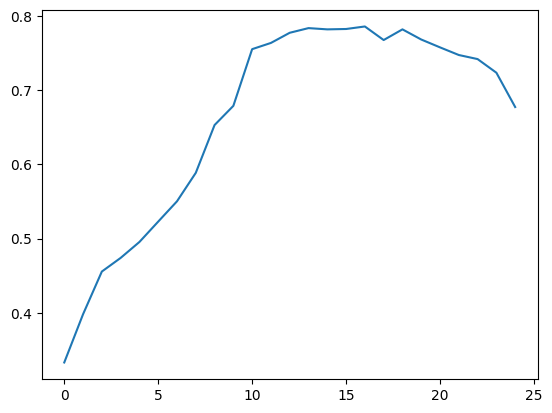

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()
x = list(values.keys())
y = [value[1][1] for value in values.items()]
ax.plot(x, y)

As we can see, the best features seem to be obtained at the middle of the network, after which the performance degrades.

Scores:    

* ImageGPT-small (features of last layer), max iter 100: 0.52582 on training set, 0.5173 on validation set.
* ImageGPT-small (features of last layer), max iter 1000: 0.69892 on training set, 0.6776 on validation set.
* ImageGPT-small (features of last layer), max iter 10000: 0.69876 on training set, 0.6776 on validation set.

Scores for ImageGPT-small with features of every layer:    
```
{'features_0': (0.35678, 0.3328),
 'features_1': (0.39662, 0.3979),
 'features_10': (0.75778, 0.7556),
 'features_11': (0.76852, 0.764),
 'features_12': (0.78118, 0.7777),
 'features_13': (0.79084, 0.784),
 'features_14': (0.79096, 0.7823),
 'features_15': (0.78704, 0.7828),
 'features_16': (0.79426, 0.7862),
 'features_17': (0.77646, 0.7679),
 'features_18': (0.79218, 0.7823),
 'features_19': (0.77898, 0.7686),
 'features_2': (0.4538, 0.4555),
 'features_20': (0.76906, 0.758),
 'features_21': (0.7632, 0.7477),
 'features_22': (0.76064, 0.7422),
 'features_23': (0.7458, 0.7238),
 'features_24': (0.69894, 0.6775),
 'features_3': (0.47694, 0.4739),
 'features_4': (0.49574, 0.4954),
 'features_5': (0.52214, 0.5229),
 'features_6': (0.55212, 0.5503),
 'features_7': (0.5959, 0.5887),
 'features_8': (0.65802, 0.6532),
 'features_9': (0.68232, 0.6791)}
```
